# Gestión Moderna de portafolio
### Autores Bernardo León y Carlos Zapata
### Copyright 2022

## Capitulo 5: Medidas de downside risk: semivarianza, VaR y CVaR

In [1]:
#Librerías usadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


### Ejemplo 5.1: Modelo Semivarianza

In [10]:
# Información histórica para las acciones: AAPL, AMZN, GOOG y MSFT
fechai = "2009-12-01"
fechaf = "2021-12-31"
periodicidad = "1Mo"
activos = ["AAPL","AMZN","GOOGL","MSFT"]
precios = yf.download(activos,start=fechai,end=fechaf,interval=periodicidad)['Adj Close'].dropna()
retornos = np.log(precios/precios.shift(1)).dropna()
mu = retornos.mean()
cov = retornos.cov()
var = np.diag(cov)
sigma = np.sqrt(var)
n = len(mu)

[*********************100%***********************]  4 of 4 completed


In [4]:
# Calculo semicovarianzas
h = 0
semiret = np.minimum(h, retornos)
semicov = semiret.cov()*12
semivar = np.diag(semicov)
semisigma = np.sqrt(semivar)
round(semicov,4)

,AAPL,AMZN,GOOGL,MSFT
AAPL,0.0187,0.0058,0.0055,0.0045
AMZN,0.0058,0.0173,0.0064,0.0054
GOOGL,0.0055,0.0064,0.0139,0.0065
MSFT,0.0045,0.0054,0.0065,0.0116


In [5]:
## Portafolios óptimos Semivarianza
unos = np.repeat(1,n)
x = mu.T @ np.linalg.inv(semicov) @ mu
y = mu.T @ np.linalg.inv(semicov) @ unos
z = unos.T @ np.linalg.inv(semicov) @ unos
d = x*z - y**2

g = (x*np.linalg.solve(semicov,unos) - y*np.linalg.solve(semicov,mu)) * (1/d)
h = (z*np.linalg.solve(semicov,mu) -  y*np.linalg.solve(semicov,unos))  * (1/d)

# Construcción de la FE
rpmin = mu.min()
rpmax = mu.max()
nport = 100

rpobj = 0.25
wpobj = g + h * rpobj 
print('w PMVGs: ', wpobj)

w PMVGs:  [0.30188737 0.2848386  0.03327515 0.37999889]


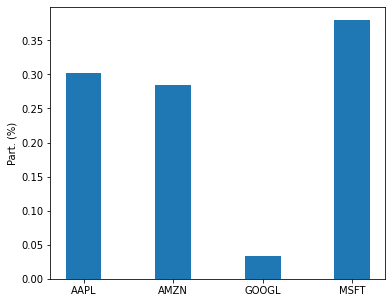

In [ ]:
# Pesos del PMVGs
fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wpobj, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

In [6]:
## Portafolio tangente de Sortino
rf = 0.0
r = mu -rf 
Z = np.linalg.solve(semicov,r) 
sumaZ = Z.sum()
wps = Z/sumaZ
rps = wps @ mu
sigmaps = np.sqrt(wps.T @ cov @ wps)
wps

array([0.31071623, 0.29399723, 0.01649865, 0.37878789])

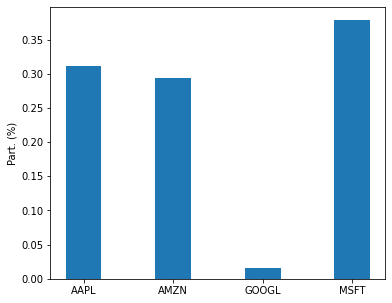

In [ ]:
# Pesos del PT de Sortino
fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wps, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

In [7]:
# FE Semivarianza
j = np.linspace(rpmin,rpmax, nport) 
wpo = np.zeros((nport, n))
rpo = np.zeros((nport,1))
semisigmapo = np.zeros((nport,1))

for i in range(nport):
    wj = g + h*j[i] 
    wpo[i,:] = wj.T
    rpo[i] = wj @ mu
    semisigmapo[i] = np.sqrt( wj.T @ semicov @ wj)

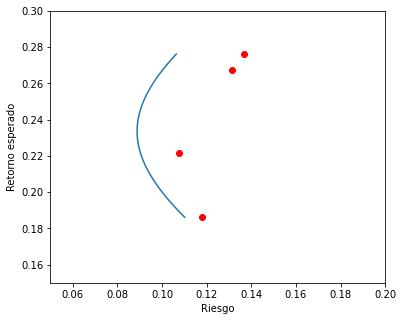

In [ ]:
# Plano Riesgo-Retorno
fig = plt.figure(figsize = (6, 5))
ax = fig.add_subplot(111)
plt.plot(semisigma, mu, "ro")
plt.plot(semisigmapo, rpo)
plt.xlabel("Riesgo")
plt.ylabel("Retorno esperado")
plt.ylim(0.15,0.3)
plt.xlim(0.05,0.2)
plt.show()

# Ejemplo 5.2: Modelo CVaR

In [52]:
# Ejemplo texto
from scipy.stats import norm
mup = 0.01
sigp = 0.02
alpha = 0.05
lev = 100*(1-alpha)
 
CVaRp = alpha**-1 * norm.pdf(norm.ppf(alpha))*sigp - mup
VaRp = norm.ppf(1-alpha)*sigp - mup

print(VaRp)
print(CVaRp)

0.022897072539029444
0.03125425615014851


## Implementación con PyPortfolioOpt

In [11]:
%pip install PyPortfolioOpt
from pypfopt import risk_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
# beta: 1 - alpha
from pypfopt import EfficientCVaR
w_optim = EfficientCVaR(mu, retornos, beta=0.95, weight_bounds=(0, 1), 
                                         solver= None, verbose=False, solver_options=None)
weights = w_optim.min_cvar()
wpcvar = round(pd.DataFrame(weights.values()),4)
wpcvar

,0
0,0.3854
1,0.1915
2,0.0000
3,0.4231
